In [82]:

import os
import fnmatch
import numpy as np
import torch
from tqdm import tqdm
import random
import json
import matplotlib.pyplot as plt
import re
from dual_network import Dual3DCNN6 as Dual
from decayLR import DecayLR
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
from torch.utils.data import Dataset, DataLoader



In [103]:
from utilities import list_patient_folders, prepare_data_nrrd, split_data

data_path_NEW = '/home/shahpouriz/Data/DBP_Project/data_checking'


patient_list_NEW = list_patient_folders(data_path_NEW)
pct_paths_NEW, rct_paths_NEW, pos_NEW = prepare_data_nrrd(data_path_NEW, patient_list_NEW)

val_data = [{
    "plan": img_path,  # Used by LoadImaged
    "repeat": repeat_path,  # Used by LoadImaged
    "pos": pos,
    "plan_path": img_path,  # Explicitly preserve the path
    "repeat_path": repeat_path  # Explicitly preserve the path
} for img_path, repeat_path, pos in zip(pct_paths_NEW, rct_paths_NEW, pos_NEW)]

val_data


[{'plan': ['/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_planningCT.nrrd'],
  'repeat': '/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_repeatedCT1.nrrd',
  'pos': array([ 0.02199666,  0.05592253, -0.0075482 ], dtype=float32),
  'plan_path': ['/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_planningCT.nrrd'],
  'repeat_path': '/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_repeatedCT1.nrrd'}]

In [104]:
#### My method

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityd
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

dim = 256
size = (dim, dim, dim)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"]),
        
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        ScaleIntensityd(keys=["plan", "repeat"]),
        Spacingd(keys=["plan", "repeat"], pixdim=(2.0, 2.0, 2.0), mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

# test_ds = CacheDataset(data=test_data, transform=transforms, cache_rate=1.0, num_workers=4)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)
# Simplified Transformations for Debugging
transforms_debug = Compose([
    LoadImaged(keys=["plan", "repeat"])
])

val_ds_debug = CacheDataset(data=val_data, transform=transforms_debug, cache_rate=1.0, num_workers=1)
val_loader_debug = DataLoader(val_ds_debug, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


In [85]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
# from monai.data import CacheDataset, DataLoader, Dataset
# import matplotlib.pyplot as plt

# # Assuming `transforms` is defined and `val_files` contains your validation files
# check_ds = Dataset(data=val_data, transform=transforms)
# check_loader = DataLoader(check_ds, batch_size=1)

# # Manually retrieve the first batch of data
# for check_data in check_loader:
#     break

# plan, repeat = (check_data["plan"][0][0], check_data["repeat"][0][0])
# print(f"image shape: {plan.shape}, target shape: {repeat.shape}")

# # plot the slice [:, :, n]
# n = 100

# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("planning")
# plt.imshow(plan[:, :, n])
# plt.subplot(1, 2, 2)
# plt.title("repeated")
# plt.imshow(repeat[:, :, n])
# plt.show()

--------------------

-----------

In [86]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming val_loader is correctly set up with the updated data format
# for batch in val_loader:
#     plan, repeat = batch["plan"][0][0].numpy(), batch["repeat"][0][0].numpy()  # Convert tensors to numpy arrays for manipulation
    
#     # Access and adjust paths if necessary (as previously discussed)
#     plan_path = batch['plan_path'][0]
#     repeat_path = batch['repeat_path'][0]
#     if isinstance(plan_path, list):
#         plan_path = plan_path[0]
#     if isinstance(repeat_path, list):
#         repeat_path = repeat_path[0]
    
#     # Extract filenames for titles
#     plan_filename = os.path.basename(plan_path)
#     repeat_filename = os.path.basename(repeat_path)

#     # Calculate the absolute difference
#     difference = np.abs(plan - repeat)
    
#     print(f"coordinate: {batch['pos'][0]}")
    
#     # Choose a slice number to visualize
#     n = 136
#     plt.figure("Difference", (18, 6))
    
#     plt.subplot(1, 3, 1)
#     plt.title(f"Planning CT\nFilename: {plan_filename}")
#     plt.imshow(plan[:, :, n], cmap='gray')
    
#     plt.subplot(1, 3, 2)
#     plt.title(f"Repeated CT\nFilename: {repeat_filename}")
#     plt.imshow(repeat[:, :, n], cmap='gray')

#     plt.subplot(1, 3, 3)
#     plt.title("Absolute Difference")
#     plt.imshow(difference[:, :, n], cmap='gray')
    
#     plt.show()
    
#     break  # Visualize the first batch only for demonstration


--------------

In [87]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import SimpleITK as sitk

# # Define the paths from the provided example
# plan_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'
# repeat_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_repeatedCT7.nrrd'

# # Load the images using SimpleITK
# plan_image_sitk = sitk.ReadImage(plan_path)
# repeat_image_sitk = sitk.ReadImage(repeat_path)

# # Convert the images to numpy arrays
# plan_image = sitk.GetArrayFromImage(plan_image_sitk)
# repeat_image = sitk.GetArrayFromImage(repeat_image_sitk)

# # Calculate the absolute difference between the two images
# difference = np.abs(plan_image - repeat_image)

# # Choose a slice number to visualize
# n = 50  # Adjust based on your images

# # Plotting
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.title(f"Raw Planning CT\n{os.path.basename(plan_path)}")
# plt.imshow(plan_image[n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.subplot(1, 3, 2)
# plt.title(f"Raw Repeated CT\n{os.path.basename(repeat_path)}")
# plt.imshow(repeat_image[n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.subplot(1, 3, 3)
# plt.title("Raw Absolute Difference")
# plt.imshow(difference[n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.show()


In [88]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd
# from monai.config import print_config
# from monai.data import Dataset, DataLoader

# # Define your transformations
# transforms = Compose([
#     LoadImaged(keys=["plan", "repeat"]),
#     EnsureChannelFirstd(keys=["plan", "repeat"]),
#     # You can add more transformations here as needed, e.g., resizing, cropping, etc.
# ])

# # Define the data dictionary
# data_dicts = [{
#     'plan': '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_planningCT.nrrd',
#     'repeat': '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_repeatedCT7.nrrd',
# }]

# # Create a dataset and dataloader to apply the transforms
# dataset = Dataset(data=data_dicts, transform=transforms)
# dataloader = DataLoader(dataset, batch_size=1, num_workers=0)

# for batch in dataloader:
#     # Extract the transformed images as numpy arrays
#     plan_image = batch['plan'][0].numpy()  # Assuming single-channel images, remove channel
#     repeat_image = batch['repeat'][0].numpy()  # Assuming single-channel images, remove channel
    
#     # Calculate the absolute difference between the two images
#     difference = np.abs(plan_image - repeat_image)

#     # Here, you can continue with the plotting part as you mentioned previously


In [89]:


# # Choose a slice number to visualize
# n = 50  # Adjust based on your images

# # Plotting
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.title(f"Transformed Planning CT\n{os.path.basename(plan_path)}")
# plt.imshow(plan_image[0, n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.subplot(1, 3, 2)
# plt.title(f"Transformed Repeated CT\n{os.path.basename(repeat_path)}")
# plt.imshow(repeat_image[0, n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.subplot(1, 3, 3)
# plt.title("Raw Absolute Difference")
# plt.imshow(difference[0, n, :, :], cmap='gray')  # Adjusted indexing for numpy's array dimension ordering

# plt.show()


-----------

In [90]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import SimpleITK as sitk

# def apply_translation(image, translation_vector):
#     """
#     Applies a translation to the given image.

#     :param image: The input image (SimpleITK image).
#     :param translation_vector: A list or tuple of three elements indicating the translation in x, y, and z directions.
#     :return: Translated image (SimpleITK image).
#     """
#     transform = sitk.TranslationTransform(3, translation_vector)
#     reference_image = image
#     translated_image = sitk.Resample(image, reference_image, transform, sitk.sitkLinear, 0.0, image.GetPixelID())
#     return translated_image

# # Define the paths
# plan_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'
# repeat_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_repeatedCT7.nrrd'

# # Load the images
# plan_image_sitk = sitk.ReadImage(plan_path)
# repeat_image_sitk = sitk.ReadImage(repeat_path)

# # Apply a simple translation to the repeat_image
# translation_vector = [10, 0, 0]  # Example translation vector (adjust as needed)
# translated_repeat_image_sitk = apply_translation(repeat_image_sitk, translation_vector)

# # Convert the images to numpy arrays
# plan_image = sitk.GetArrayFromImage(plan_image_sitk)
# translated_repeat_image = sitk.GetArrayFromImage(translated_repeat_image_sitk)

# # Calculate the absolute difference between the translated repeat image and the planning image
# difference = np.abs(plan_image - translated_repeat_image)

# # Choose a slice number to visualize
# n = 50

# # Plotting
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.title(f"Raw Planning CT\n{os.path.basename(plan_path)}")
# plt.imshow(plan_image[n, :, :], cmap='gray')

# plt.subplot(1, 3, 2)
# plt.title(f"Translated Repeated CT\n{os.path.basename(repeat_path)}")
# plt.imshow(translated_repeat_image[n, :, :], cmap='gray')

# plt.subplot(1, 3, 3)
# plt.title("Raw Absolute Difference After Translation")
# plt.imshow(difference[n, :, :], cmap='gray')

# plt.show()


In [91]:
# import SimpleITK as sitk
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# # Function to load an image using SimpleITK and convert to numpy array
# def load_image(path):
#     sitk_image = sitk.ReadImage(path)
#     image_array = sitk.GetArrayFromImage(sitk_image)
#     # SimpleITK reads images as [z, y, x], convert to [x, y, z] for consistency
#     image_array = np.transpose(image_array, (2, 1, 0))
#     return image_array

# # Assuming you have a list of dictionaries with 'plan_path' and 'repeat_path'
# for item in data_NEW[:1]:  # Replace data_NEW[:1] with your data list to plot more images
#     plan_path = item['plan']
#     repeat_path = item['repeat']
    
#     # Check if paths are lists and extract first item if necessary
#     if isinstance(plan_path, list):
#         plan_path = plan_path[0]
#     if isinstance(repeat_path, list):
#         repeat_path = repeat_path[0]

#     # Load images
#     plan_image = load_image(plan_path)
#     repeat_image = load_image(repeat_path)

#     print(plan_path)
#     print(repeat_path)
#     # Calculate the absolute difference
#     difference = np.abs(plan_image - repeat_image)

#     # Choose a slice number to visualize
#     n = 50  # Adjust based on your images
    
#     # Plotting
#     plt.figure(figsize=(18, 6))
    
#     plt.subplot(1, 3, 1)
#     plt.title(f"Raw Planning CT\n{os.path.basename(plan_path)}")
#     plt.imshow(plan_image[:, :, n], cmap='gray')
    
#     plt.subplot(1, 3, 2)
#     plt.title(f"Raw Repeated CT\n{os.path.basename(repeat_path)}")
#     plt.imshow(repeat_image[:, :, n], cmap='gray')

#     plt.subplot(1, 3, 3)
#     plt.title("Raw Absolute Difference")
#     plt.imshow(difference[:, :, n], cmap='gray')
    
#     plt.show()


-----------------

--------------------

In [92]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(path):
    sitk_image = sitk.ReadImage(path)
    image_array = sitk.GetArrayFromImage(sitk_image)
    image_array = np.transpose(image_array, (2, 1, 0))  # Convert to [x, y, z]
    return image_array

def plot_images(plan, repeat, difference, n, title_prefix=""):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}Planning CT")
    plt.imshow(plan[:, :, n], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix}Repeated CT")
    plt.imshow(repeat[:, :, n], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix}Difference")
    plt.imshow(difference[:, :, n], cmap='gray')
    
    plt.show()




In [105]:
# Assuming val_loader is set up for transformed data
for batch in val_loader:
    # Transformed images and paths
    plan_transformed, repeat_transformed = batch["plan"][0][0].numpy(), batch["repeat"][0][0].numpy()
    plan_path = batch['plan_path'][0]  # Direct access to path
    repeat_path = batch['repeat_path'][0]  # Direct access to path

    # Adjust if paths are lists
    if isinstance(plan_path, list): plan_path = plan_path[0]
    if isinstance(repeat_path, list): repeat_path = repeat_path[0]

    # Original images
    plan_original = load_image(plan_path).astype(np.float32)
   
    repeat_original = load_image(repeat_path).astype(np.float32)



    # Calculate absolute differences
    difference_original = np.abs(plan_original - repeat_original)
    difference_transformed = np.abs(plan_transformed - repeat_transformed)

    # Plot original images and their difference
    plot_images(plan_original, repeat_original, difference_original, n=50, title_prefix="Original ")
    
    # Plot transformed images and their difference
    plot_images(plan_transformed, repeat_transformed, difference_transformed, n=135, title_prefix="Transformed ")

    break  # Plot for the first set only for demonstration


TypeError: plot_images() got an unexpected keyword argument 'n'

/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_planningCT.nrrd
/home/shahpouriz/Data/DBP_Project/data_checking/DBP_HN044/DBP_HN044_P2_repeatedCT1.nrrd


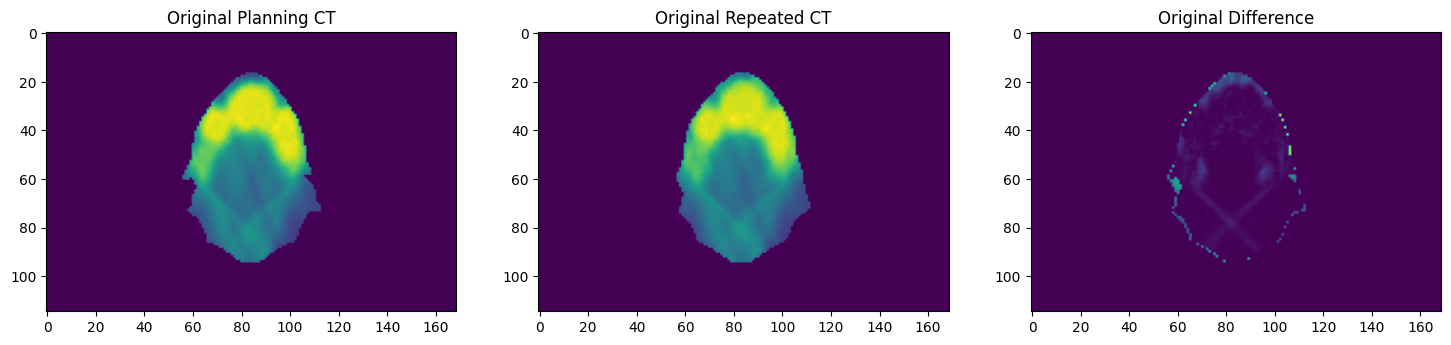

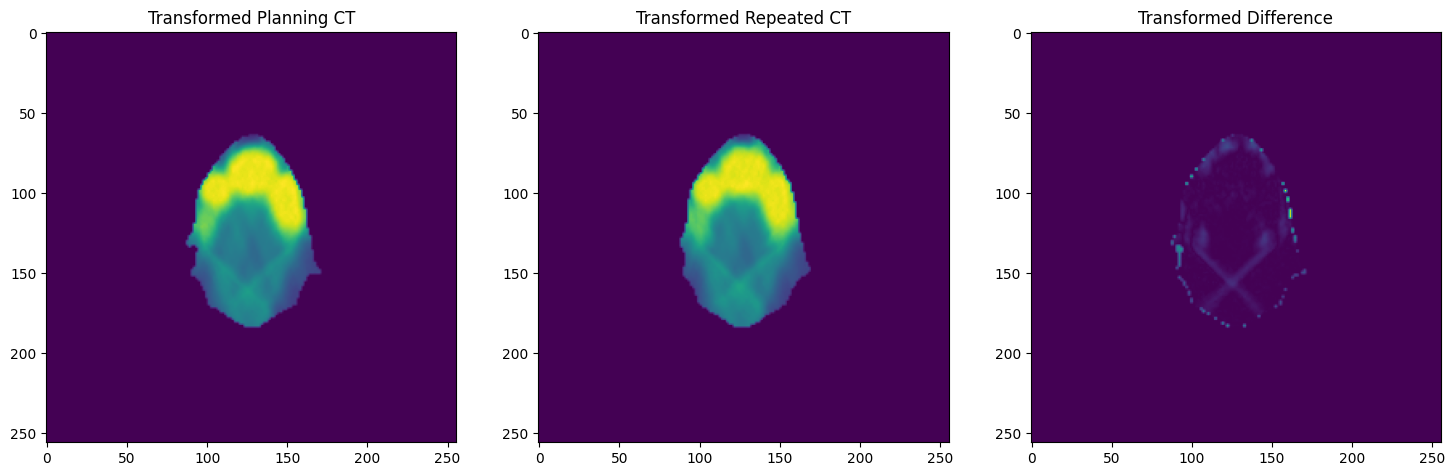

In [114]:
def calculate_transformed_slice_index(n_original, original_depth, transformed_depth):
    """
    Calculate the corresponding slice index in the transformed image based on the original slice index.
    
    Parameters:
    - n_original: The slice index in the original image.
    - original_depth: The number of slices in the original image's depth.
    - transformed_depth: The number of slices in the transformed image's depth.
    
    Returns:
    - n_transformed: The corresponding slice index in the transformed image.
    """
    original_center = original_depth // 2
    offset = n_original - original_center
    n_transformed_center = transformed_depth // 2
    n_transformed = n_transformed_center + offset
    return n_transformed


def plot_images(plan, repeat, difference, n, title_prefix=""):
    plt.figure(figsize=(18, 6))
    
    # Rotate the plan image by 3*90 degrees
    plan_rotated = np.rot90(plan[:, :, n], k=3)
    repeat_rotated = np.rot90(repeat[:, :, n], k=3)
    difference_rotated = np.rot90(difference[:, :, n], k=3)
    
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}Planning CT")
    plt.imshow(plan_rotated, cmap='viridis') 
    
    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix}Repeated CT")
    plt.imshow(repeat_rotated, cmap='viridis')  

    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix}Difference")
    plt.imshow(difference_rotated, cmap='viridis') 
    
    plt.show()


for batch in val_loader:
    # Transformed images and paths
    plan_transformed, repeat_transformed = batch["plan"][0][0].numpy(), batch["repeat"][0][0].numpy()
    plan_path = batch['plan_path'][0]  # Direct access to path
    repeat_path = batch['repeat_path'][0]  # Direct access to path

    # Adjust if paths are lists
    if isinstance(plan_path, list): plan_path = plan_path[0]
    if isinstance(repeat_path, list): repeat_path = repeat_path[0]

    # Original images
    plan_original = load_image(plan_path).astype(np.float32)
    repeat_original = load_image(repeat_path).astype(np.float32)



    # Calculate absolute differences
    difference_original = np.abs(plan_original - repeat_original)
    difference_transformed = np.abs(plan_transformed - repeat_transformed)

    n_original = 60
    n_transformed = 118

    print(plan_path)
    print(repeat_path)
    # Plot original images and their difference
    plot_images(plan_original, repeat_original, difference_original, n_original, title_prefix="Original ")
    
    # Plot transformed images and their difference
    plot_images(plan_transformed, repeat_transformed, difference_transformed, n_transformed, title_prefix="Transformed ")

      # Plot for the first set only for demonstration


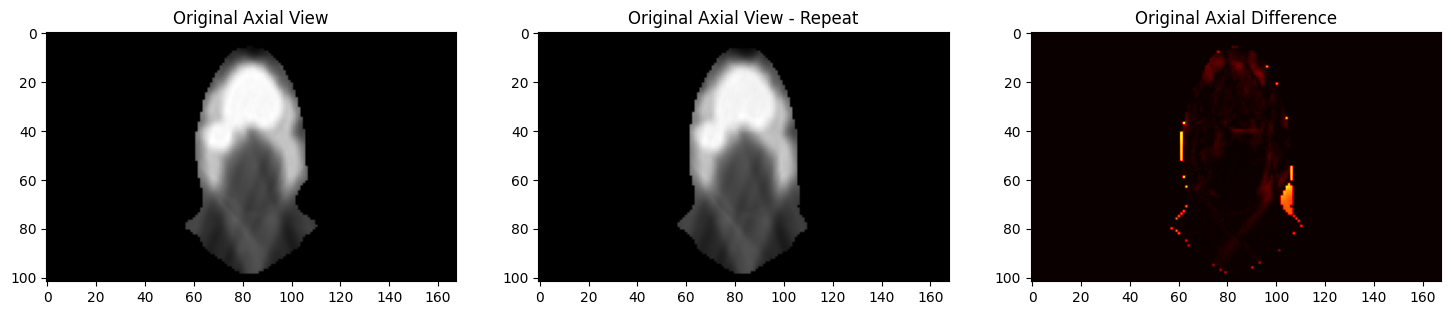

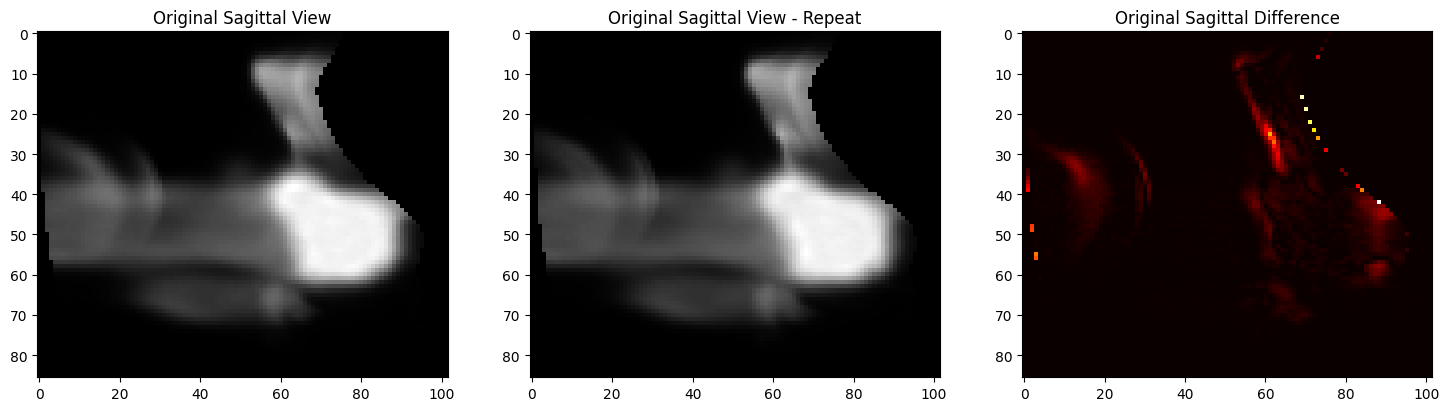

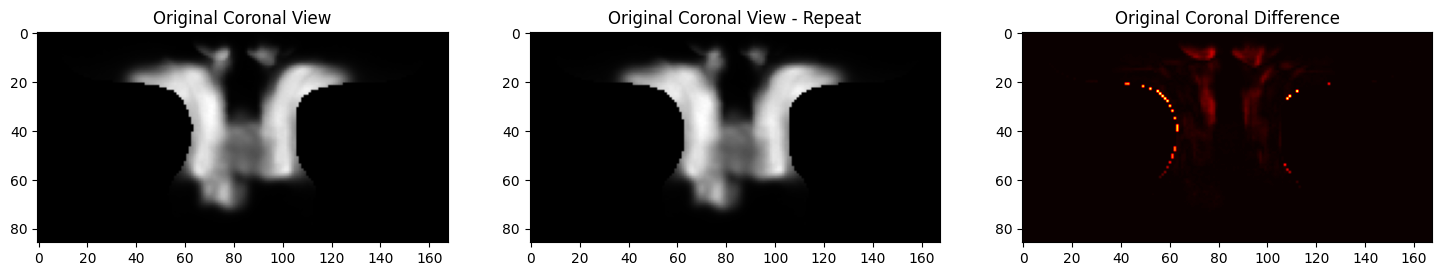

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os

def load_image(path):
    sitk_image = sitk.ReadImage(path)
    image_array = sitk.GetArrayFromImage(sitk_image)
    image_array = np.transpose(image_array, (2, 1, 0))  # SimpleITK reads images as [z, y, x], convert to [x, y, z]
    return image_array

def plot_images(plan, repeat, difference, n_axial, n_sagittal, n_coronal, title_prefix=""):
    plt.figure(figsize=(18, 6))
    
        # plan_rotated = np.rot90(plan[:, :, n], k=3)
    # Axial
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}Axial View")
    plt.imshow(np.rot90(plan[:, :, n_axial], k=3), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix}Axial View - Repeat")
    plt.imshow(np.rot90(repeat[:, :, n_axial], k=3), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix}Axial Difference")
    plt.imshow(np.rot90(difference[:, :, n_axial], k=3), cmap='hot')
    
    plt.figure(figsize=(18, 6))
    
    # Sagittal
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}Sagittal View")
    plt.imshow(np.rot90(plan[n_sagittal, :, :], k=3), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix}Sagittal View - Repeat")
    plt.imshow(np.rot90(repeat[n_sagittal, :, :], k=3), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix}Sagittal Difference")
    plt.imshow(np.rot90(difference[n_sagittal, :, :], k=3), cmap='hot')
    
    plt.figure(figsize=(18, 6))
    
    # Coronal
    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix}Coronal View")
    plt.imshow(np.rot90(plan[:, n_coronal, :], k=3), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix}Coronal View - Repeat")
    plt.imshow(np.rot90(repeat[:, n_coronal, :], k=3), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix}Coronal Difference")
    plt.imshow(np.rot90(difference[:, n_coronal, :], k=3), cmap='hot')
    
    plt.show()

# Assuming val_loader is set up for transformed data
for batch in val_loader:
    plan_transformed, repeat_transformed = batch["plan"][0][0].numpy(), batch["repeat"][0][0].numpy()
    plan_path = batch['plan_path'][0]
    repeat_path = batch['repeat_path'][0]

    if isinstance(plan_path, list): plan_path = plan_path[0]
    if isinstance(repeat_path, list): repeat_path = repeat_path[0]

    plan_original = load_image(plan_path).astype(np.float32)
    repeat_original = load_image(repeat_path).astype(np.float32)

    difference_original = np.abs(plan_original - repeat_original)
    difference_transformed = np.abs(plan_transformed - repeat_transformed)

    # Example slice indices for original and transformed orientations
    n_axial = 50  # Original axial slice
    n_sagittal = plan_original.shape[0] // 2  # Middle sagittal slice
    n_coronal = plan_original.shape[1] // 2  # Middle coronal slice

    # Plot original images and their difference in all views
    plot_images(plan_original, repeat_original, difference_original, n_axial, n_sagittal, n_coronal, title_prefix="Original ")

    # For transformed images, you might want to adjust slice indices based on the new dimensions
    n_axial_trans = 135  # Previously calculated corresponding axial slice for transformed
    n_sagittal_trans = plan_transformed.shape[0] // 2
    n_coronal_trans = plan_transformed.shape[1] // 2
    
    # Plot


-----------------

In [96]:
# import SimpleITK as sitk
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# # Function to load an image using SimpleITK and convert to numpy array
# def load_image(path):
#     sitk_image = sitk.ReadImage(path)
#     image_array = sitk.GetArrayFromImage(sitk_image)
#     image_array = np.transpose(image_array, (2, 1, 0))  # Convert from [z, y, x] to [x, y, z]
#     return image_array

# # Assume `n_transformed` is known from previous calculation
# n_transformed = 135

# # Plot for a specific item in your dataset
# item = data_NEW[0]  # Replace with how you access a specific item, e.g., based on a condition

# # Load and prepare original images
# plan_path = item['plan']
# repeat_path = item['repeat']
# if isinstance(plan_path, list):
#     plan_path = plan_path[0]
# if isinstance(repeat_path, list):
#     repeat_path = repeat_path[0]

# plan_image = load_image(plan_path).astype(np.float32)
# repeat_image = load_image(repeat_path).astype(np.float32)
# difference = np.abs(plan_image - repeat_image)

# # Original image plotting (n = 50 as an example)
# n_original = 50
# plt.figure("Original Images", (18, 6))
# plt.subplot(1, 3, 1)
# plt.title("Original Planning CT")
# plt.imshow(plan_image[:, :, n_original], cmap='gray')
# plt.subplot(1, 3, 2)
# plt.title("Original Repeated CT")
# plt.imshow(repeat_image[:, :, n_original], cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title("Original Difference")
# plt.imshow(difference[:, :, n_original], cmap='gray')
# plt.show()

# # Transformed image plotting (using DataLoader)
# for batch in val_loader:  # Assuming `val_loader` is your DataLoader
#     plan, repeat = batch["plan"][0][0].numpy(), batch["repeat"][0][0].numpy()
#     difference_transformed = np.abs(plan - repeat)
    
#     plt.figure("Transformed Images", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("Transformed Planning CT")
#     plt.imshow(plan[:, :, n_transformed], cmap='gray')
#     plt.subplot(1, 3, 2)
#     plt.title("Transformed Repeated CT")
#     plt.imshow(repeat[:, :, n_transformed], cmap='gray')
#     plt.subplot(1, 3, 3)
#     plt.title("Transformed Difference")
#     plt.imshow(difference_transformed[:, :, n_transformed], cmap='gray')
#     plt.show()
    
#     break  # Assuming you want to plot just the first matched set for demonstration


-------------

In [97]:
# import SimpleITK as sitk
# import numpy as np

# def load_image_sitk(path):
#     sitk_image = sitk.ReadImage(path)
#     image_array = sitk.GetArrayFromImage(sitk_image)
#     # Transpose to [x, y, z], similar to MONAI's expected output
#     image_array = np.transpose(image_array, (2, 1, 0))
#     return image_array



# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd
# from monai.data import Dataset
# from monai.transforms import ScaleIntensityd

# # Define your transformations
# transforms = Compose([
#     LoadImaged(keys=["plan", "repeat"]),
#     EnsureChannelFirstd(keys=["plan", "repeat"]),
#     ScaleIntensityd(keys=["plan", "repeat"]),
# ])

# # Define the data dictionary
# data_dicts = [{
#     'plan': '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_planningCT.nrrd',
#     'repeat': '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_repeatedCT7.nrrd',
# }]

# # Define the paths from the provided example
# plan_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'
# repeat_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/data_checking/DBP_OP013/DBP_OP013_P1_repeatedCT7.nrrd'

# # Apply transformations
# dataset = Dataset(data=data_dicts, transform=transforms)
# data_transformed = dataset[0]  # Assuming you're interested in the first item for simplicity

# # Extract and adjust the images from the transformed dataset
# plan_image_monai = data_transformed['plan']
# repeat_image_monai = data_transformed['repeat']

# # Since MONAI adds a channel dimension, remove it and transpose to match [x, y, z]
# plan_image_monai = np.squeeze(plan_image_monai, axis=0).transpose(0, 1, 2)
# repeat_image_monai = np.squeeze(repeat_image_monai, axis=0).transpose(0, 1, 2)

# # Load directly with SimpleITK
# plan_image_sitk = load_image_sitk(plan_path)
# repeat_image_sitk = load_image_sitk(repeat_path)

# plan_image_sitk = plan_image_sitk.astype(np.float32)
# repeat_image_sitk = repeat_image_sitk.astype(np.float32)


# difference_sitk = np.abs(plan_image_sitk - repeat_image_sitk)
# difference_monai = np.abs(plan_image_monai - repeat_image_monai)

# # Optionally, visualize or further analyze the differences
# # This could involve plotting or computing some metrics to quantify the differences


In [98]:
# import matplotlib.pyplot as plt

# def plot_images(plan_image, repeat_image, difference, title_prefix=''):
#     # Choose a slice for comparison; adjust as needed
#     slice_index = plan_image.shape[2] // 2  # Middle slice

#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#     axs[0].imshow(plan_image[:, :, slice_index], cmap='gray')
#     axs[0].set_title(f'{title_prefix} Planning CT')

#     axs[1].imshow(repeat_image[:, :, slice_index], cmap='gray')
#     axs[1].set_title(f'{title_prefix} Repeated CT')

#     axs[2].imshow(difference[:, :, slice_index], cmap='gray')
#     axs[2].set_title(f'{title_prefix} Difference')

#     for ax in axs:
#         ax.axis('off')
#     plt.show()

# # Assuming 'plan_image_sitk', 'repeat_image_sitk', 'plan_image_monai', and 'repeat_image_monai' are defined
# difference_sitk = np.abs(plan_image_sitk - repeat_image_sitk)
# difference_monai = np.abs(plan_image_monai - repeat_image_monai)

# plot_images(plan_image_sitk, repeat_image_sitk, difference_sitk, 'SimpleITK')
# plot_images(plan_image_monai, repeat_image_monai, difference_monai, 'MONAI')


In [99]:
# # For the SimpleITK-loaded images
# print(f"SimpleITK Plan Image Data Type: {plan_image_sitk.dtype}")
# print(f"SimpleITK Repeat Image Data Type: {repeat_image_sitk.dtype}")

# # For the MONAI-transformed images
# print(f"MONAI Plan Image Data Type: {plan_image_monai.dtype}")
# print(f"MONAI Repeat Image Data Type: {repeat_image_monai.dtype}")
